<a href="https://colab.research.google.com/github/namwootree/Basic_Skill/blob/main/Unsupervised%20Learning/%ED%95%B8%EC%A6%88%EC%98%A8%20%EB%B9%84%EC%A7%80%EB%8F%84%20%ED%95%99%EC%8A%B5/Ch_4_%EC%9D%B4%EC%83%81%EC%B9%98_%ED%83%90%EC%A7%80.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setting

## 라이브러리 업그레이드

In [96]:
!pip install scikit-learn --upgrade

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 9.7 MB 5.2 MB/s 
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.0.2
    Uninstalling scikit-learn-1.0.2:
      Successfully uninstalled scikit-learn-1.0.2


In [43]:
import sklearn
print(sklearn.__version__)

1.2.0


## Library

In [1]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.metrics import roc_curve, auc, roc_auc_score

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
color = sns.color_palette()

In [70]:
from sklearn.decomposition import PCA, SparsePCA, KernelPCA

from sklearn.random_projection import GaussianRandomProjection, SparseRandomProjection

from sklearn.decomposition import MiniBatchDictionaryLearning, FastICA

## Google Drive Mount

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Load Data Set

In [4]:
file_path = '/content/drive/MyDrive/머신러닝 엔지니어링/핸즈온 비지도 학습/data/creditcard.csv'

data = pd.read_csv(file_path)

In [5]:
data.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


# Preprocessing

In [6]:
X = data.copy().drop(columns='Class')
y = data['Class'].copy()

In [7]:
Features2Scale = X.columns

scaler = StandardScaler(copy=True)

X.loc[:,Features2Scale] = scaler.fit_transform(X[Features2Scale])

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.33,
                                                    stratify=y,
                                                    random_state=2022)

In [9]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(190820, 30)
(93987, 30)
(190820,)
(93987,)


# 제귀 함수 정의

## 이상치 스코어 정의

* 차원 축소 알고리즘은 가능한 축소된 피처셋으로부터 원본 피처셋으로 재구성할 수 있도록 원본 피처의 핵심 정보를 추출하려고 시도함

* 그라나 기존보다 더 낮은 차원 공간으로 이동하면서 원본 피처의 모든 정보를 추출할 수 없음

* 따라서 해당 알고리즘으로 축소된 피처셋을 원본 차원 수로 다시 구성하면 오차가 발생함



* 사기는 드물고 정상 거래와 다를 수 있으므로 사기 거래는 가장 큰 재구성 오차를 나타내야 한다

* 각 거래의 재구성 오차는 원본 피처 행렬과 차원 축소 알고리즘을 사용해 재구성된 행렬 간 차이 제곱 합이다

* 전체 데이터 셋에 대한 차이 제곱 합의 최대-최소 범위를 구해서 차이 제곱 합의 범위를 정규화한다

* 이렇게 하면 모든 재구성 오차가 0에서 1 사이의 범위에 놓이게 된다

* 0은 정상이고 1은 비정상이다

In [10]:
def anomaly_scores(orignal_DF, reduced_DF):

  loss = np.sum(
                (np.array(orignal_DF)-np.array(reduced_DF)) ** 2,
                axis=1
                )
  
  loss = pd.Series(data=loss,
                   index=orignal_DF.index)
  
  loss = (loss-np.min(loss)) / (np.max(loss)-np.min(loss))

  return loss

## 평가 지표 정의

In [11]:
def plotResults(trueLabels, anomalyScores, returnPreds = False):

    preds = pd.concat([trueLabels, anomalyScores], axis=1)
    preds.columns = ['trueLabel', 'anomalyScore']

    precision, recall, thresholds = precision_recall_curve(preds['trueLabel'],
                                                           preds['anomalyScore'])
    average_precision = average_precision_score(preds['trueLabel'],
                                                preds['anomalyScore'])
    
    plt.step(recall, precision, color='k', alpha=0.7, where='post')
    plt.fill_between(recall, precision, step='post', alpha=0.3, color='k')

    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    
    plt.title('Precision-Recall curve: Average Precision = \
    {0:0.2f}'.format(average_precision))

    fpr, tpr, thresholds = roc_curve(preds['trueLabel'],
                                     preds['anomalyScore'])
    
    areaUnderROC = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, color='r', lw=2, label='ROC curve')
    plt.plot([0, 1], [0, 1], color='k', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic: \
    Area under the curve = {0:0.2f}'.format(areaUnderROC))
    plt.legend(loc="lower right")
    plt.show()
    
    if returnPreds==True:
        return preds

## 시각화 함수 정의

In [12]:
def scatterPlot(xDF, yDF, algoName):
    tempDF = pd.DataFrame(data=xDF.loc[:,0:1], index=xDF.index)
    tempDF = pd.concat((tempDF,yDF), axis=1, join="inner")
    tempDF.columns = ["First Vector", "Second Vector", "Label"]
    sns.lmplot(x="First Vector", y="Second Vector", hue="Label", \
               data=tempDF, fit_reg=False)
    ax = plt.gca()
    ax.set_title("Separation of Observations using "+algoName)

# 이상치 탐지

## 선형 차원 축소

### 일반 PCA


* 거래 데이터 셋의 내재된 구조를 학습

* 데이터 셋의 구조를 학습한 후, 학습된 모델을 사용해 신용카드 거래를 재구성한 다음 재구성된 거래 데이터와 원본 데이터 거래 데이터가 얼마나 차이가 나는지 계산

* PCA를 통해 재구성이 어려운 거래가 가장 비정상

* PCA에서 재구성 오차는 주성분 개수에 크게 좌우되며, 원본 거래 데이터를 재구성하는 데 사용함

* 주성분이 많을수록 PCA는 원본 거래 데이터의 내재된 구조를 더 잘 학습할 수 있음

* 그러나 주성분이 너무 많으면 PCA는 원본 거래 데이터를 너무 쉽게 재구성할 수 있으므로 모든 거래 데이터에 재구성 오차가 최소화됨

* 주성분이 너무 작다면 PCA는 정상 거래조차 충분히 재구성하지 못할 수 있음

In [13]:
n_components = 30
whiten = False
random_state = 2022

In [14]:
pca = PCA(n_components=n_components,
          whiten=whiten,
          random_state=random_state)

In [15]:
X_train_PCA = pca.fit_transform(X_train)
X_train_PCA = pd.DataFrame(data=X_train_PCA, index=X_train.index)

In [16]:
X_train_PCA.head()

,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
182264,-0.258671,0.221728,0.272061,0.047571,-0.207575,-0.149720,-0.008604,-0.526175,0.136429,1.447503,...,1.738872,1.200207,-0.058777,-2.373239,-0.515875,-0.030309,-0.273139,-0.014207,-0.648663,0.033206
113153,-0.365994,-0.838466,0.052624,0.110531,-0.026867,-0.217431,-0.319130,0.213365,0.969144,-0.609394,...,-0.076674,-0.286749,-1.676734,0.083629,0.313266,0.113509,-0.137197,-0.035921,-0.168401,0.032153
46303,-0.313920,-1.510033,0.082338,0.179705,0.977888,0.486570,-0.602124,-0.927499,-0.443722,0.237808,...,1.577185,0.593664,2.430888,-0.822830,-1.124374,0.102012,-0.122227,-0.447920,0.064510,0.074862
156603,-0.362880,-1.386716,0.253443,-0.373810,-0.058258,0.939820,-0.573245,0.571408,-0.035027,0.546571,...,-0.033758,0.926656,2.227491,1.518963,-0.274441,-0.038881,0.125937,-0.240949,-1.766075,0.000571
258117,-0.175990,0.608109,0.202374,0.268996,-0.573487,0.353603,-0.083784,-0.118101,-0.714956,1.702522,...,0.028544,-0.282352,-0.065871,-0.041240,-0.003607,0.375935,-0.308136,-0.461358,-1.268669,-0.015651


In [17]:
X_train_PCA_inverse = pca.inverse_transform(X_train_PCA)
X_train_PCA_inverse = pd.DataFrame(data=X_train_PCA_inverse,
                                   index=X_train.index)

In [18]:
X_train_PCA_inverse.head()

,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
182264,0.642501,-0.392415,0.088590,0.327590,-1.076116,0.442790,-0.867286,0.882229,-0.198945,-1.911321,...,-0.531352,-0.240616,-0.287453,-0.717008,0.152989,1.896028,1.921768,-0.259870,0.046412,-0.193226
113153,-0.460239,0.588505,-0.024587,0.468473,0.650517,-0.440439,-0.235333,-0.156985,0.010081,0.532417,...,-0.202725,-0.050424,0.233918,-0.035016,0.785359,0.901681,0.926600,0.001585,0.034908,-0.313249
46303,-1.096925,-0.376321,-0.085221,1.513943,-1.796484,-0.927371,-0.461678,-0.483117,-0.769686,-1.567431,...,-0.495607,0.853920,-0.119192,-0.364618,0.505059,0.687760,-0.385316,0.449434,-0.278546,-0.342035
156603,0.287865,-0.328304,0.451215,1.461461,-0.213956,0.136004,0.114146,0.312062,-0.077899,1.367465,...,-0.004601,-0.375470,-0.641636,-0.520004,-0.773692,0.448841,-1.527503,-0.561385,-0.472634,-0.308171
258117,1.341161,-0.675401,0.527538,0.533241,-0.624847,0.427195,0.322602,0.549255,0.318176,-0.353550,...,0.105537,-0.105088,-0.251697,-0.752607,0.182709,1.330909,0.677824,-0.390369,-0.733568,-0.109746


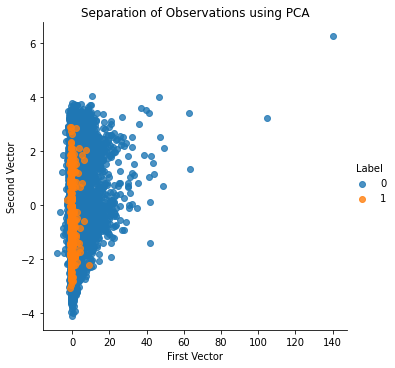

In [19]:
scatterPlot(X_train_PCA, y_train, "PCA")

* 주성분의 수가 원본 차원의 수와 같으면 PCA는 주성분을 생성할 때 데이터의 분산/정보를 거의 100% 추출함

* 사기 또는 다른 모든 거래에 대한 재구성 오차가 너무 작게 발생함

* 이상치를 제대로 탐지하지 못함

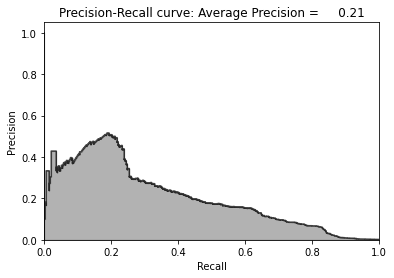

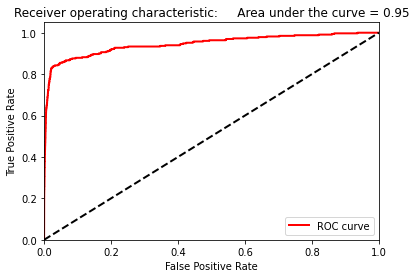

In [20]:
anomalyScoresPCA = anomaly_scores(X_train, X_train_PCA_inverse)
preds = plotResults(y_train, anomalyScoresPCA, True)

In [21]:
n_components = 27
whiten = False
random_state = 2022

In [22]:
pca = PCA(n_components=n_components,
          whiten=whiten,
          random_state=random_state)

In [23]:
X_train_PCA = pca.fit_transform(X_train)
X_train_PCA = pd.DataFrame(data=X_train_PCA, index=X_train.index)

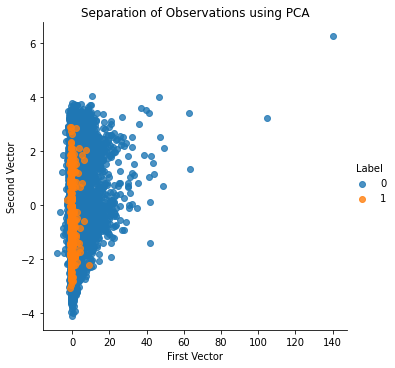

In [24]:
scatterPlot(X_train_PCA, y_train, "PCA")

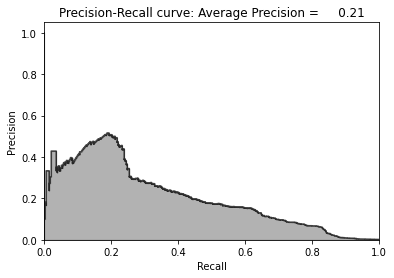

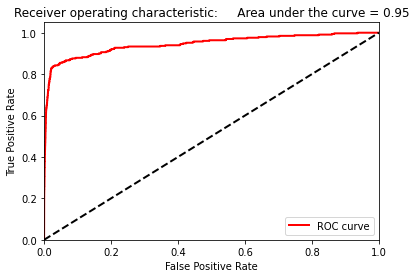

In [25]:
anomalyScoresPCA = anomaly_scores(X_train, X_train_PCA_inverse)
preds = plotResults(y_train, anomalyScoresPCA, True)

* 가장 높은 재구성 오차가 맨 위로 가도록 내림차순으로 정렬하고 해당 목록 상위 350건을 추출하면 그 중 99건이 사기 거래인 것을 확인할 수 있음


In [26]:
preds.sort_values(by="anomalyScore",ascending=False,inplace=True)
cutoff = 350
predsTop = preds[:cutoff]

print("Precision: ",np.round(predsTop. \
            anomalyScore[predsTop.trueLabel==1].count()/cutoff,2))
print("Recall: ",np.round(predsTop. \
            anomalyScore[predsTop.trueLabel==1].count()/y_train.sum(),2))
print("Fraud Caught out of 330 Cases:", predsTop.trueLabel.sum())

Precision:  0.28
Recall:  0.3
Fraud Caught out of 330 Cases: 99


### 희소 PCA

In [27]:
n_components = 27
alpha = 0.0001
random_state = 2022
n_jobs = -1

In [28]:
sparsePCA = SparsePCA(n_components=n_components,
                      alpha=alpha,
                      random_state=random_state,
                      n_jobs=n_jobs)

In [29]:
X_train_sparsePCA = sparsePCA.fit_transform(X_train)
X_train_sparsePCA = pd.DataFrame(data=X_train_sparsePCA, index=X_train.index)

In [30]:
X_train_sparsePCA_inverse = pca.inverse_transform(X_train_sparsePCA)
X_train_sparsePCA_inverse = pd.DataFrame(data=X_train_sparsePCA_inverse,
                                         index=X_train.index)

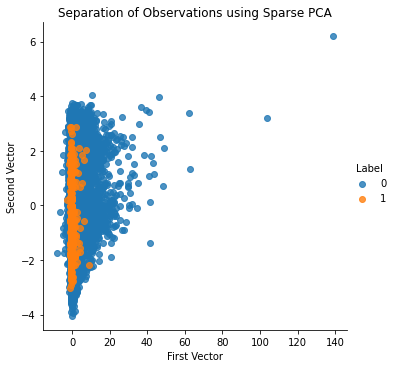

In [31]:
scatterPlot(X_train_sparsePCA, y_train, "Sparse PCA")

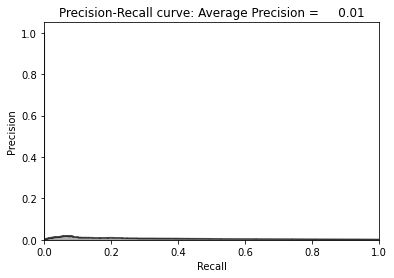

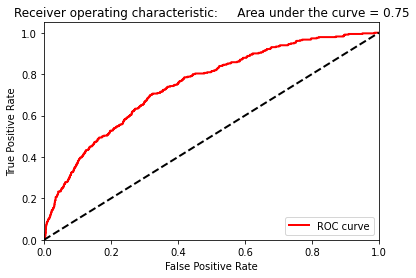

In [32]:
anomalyScoresSparsePCA = anomaly_scores(X_train, X_train_sparsePCA_inverse)
preds = plotResults(y_train, anomalyScoresSparsePCA, True)

### 커널 PCA

In [33]:
n_components = 27
kernel = 'rbf'
gamma = 1/30
fit_inverse_transform = True
random_state = 2022
n_jobs = 1

In [34]:
kernelPCA = KernelPCA(n_components=n_components,
                      kernel=kernel,
                      gamma=gamma,
                      fit_inverse_transform=fit_inverse_transform,
                      n_jobs=n_jobs,
                      random_state=random_state)

In [35]:
kernelPCA.fit(X_train.iloc[:2000])

X_train_kernelPCA = kernelPCA.transform(X_train)
X_train_kernelPCA = pd.DataFrame(data=X_train_kernelPCA,
                                 index=X_train.index)

In [36]:
X_train_kernelPCA_inverse = kernelPCA.inverse_transform(X_train_kernelPCA)
X_train_kernelPCA_inverse = pd.DataFrame(data=X_train_kernelPCA_inverse,
                                         index=X_train.index)

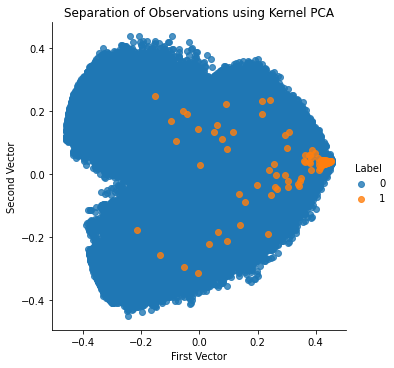

In [37]:
scatterPlot(X_train_kernelPCA, y_train, "Kernel PCA")

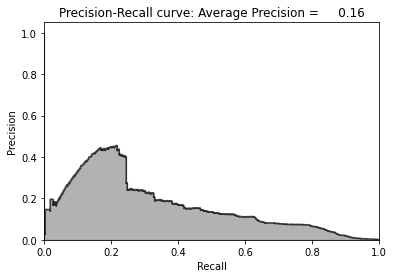

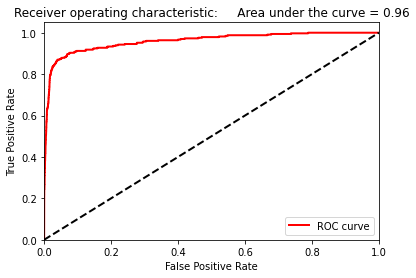

In [38]:
anomalyScoresKernelPCA = anomaly_scores(X_train, X_train_kernelPCA_inverse)
preds = plotResults(y_train, anomalyScoresKernelPCA, True)

### GRP

In [47]:
n_components = 27
eps = 0.01
random_state = 2022

In [48]:
GRP = GaussianRandomProjection(n_components=n_components,
                               eps=eps,
                               random_state=random_state)

In [49]:
X_train_GRP = GRP.fit_transform(X_train)
X_train_GRP = pd.DataFrame(data=X_train_GRP, index=X_train.index)

In [50]:
X_train_GRP_inverse = GRP.inverse_transform(X_train_GRP)
X_train_GRP_inverse = pd.DataFrame(data=X_train_GRP_inverse,
                                         index=X_train.index)

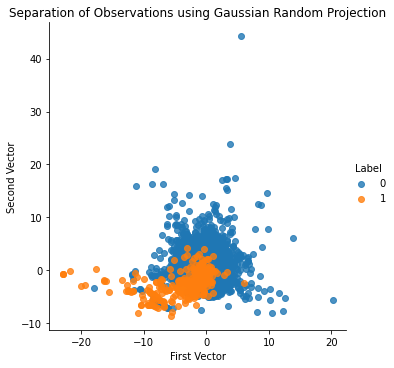

In [51]:
scatterPlot(X_train_GRP, y_train, "Gaussian Random Projection")

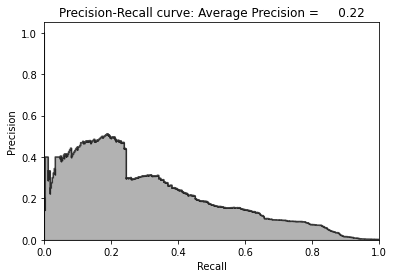

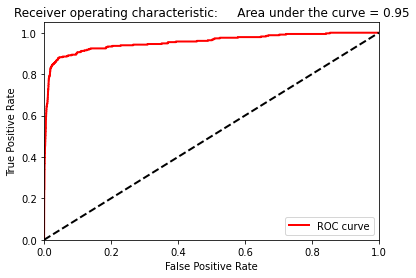

In [53]:
X_train_GRP_inverse = np.array(X_train_GRP).dot(GRP.components_)
X_train_GRP_inverse = pd.DataFrame(data=X_train_GRP_inverse,
                                   index=X_train.index)

anomalyScoresGRP = anomaly_scores(X_train, X_train_GRP_inverse)
preds = plotResults(y_train, anomalyScoresGRP, True)

### SRP

In [56]:
n_components = 27
density = 'auto'
eps = 0.01
dense_output = True
random_state = 2022

In [57]:
SRP = SparseRandomProjection(n_components=n_components,
                             density=density,
                             eps=eps,
                             dense_output=dense_output,
                             random_state=random_state)

In [58]:
X_train_SRP = SRP.fit_transform(X_train)
X_train_SRP = pd.DataFrame(data=X_train_SRP, index=X_train.index)

In [59]:
X_train_SRP_inverse = np.array(X_train_SRP).dot(SRP.components_.todense())
X_train_SRP_inverse = pd.DataFrame(data=X_train_SRP_inverse, index=X_train.index)

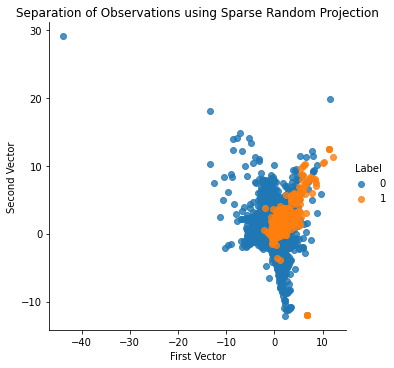

In [60]:
scatterPlot(X_train_SRP, y_train, "Sparse Random Projection")

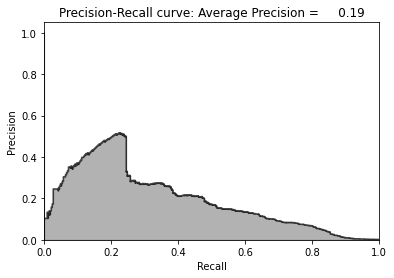

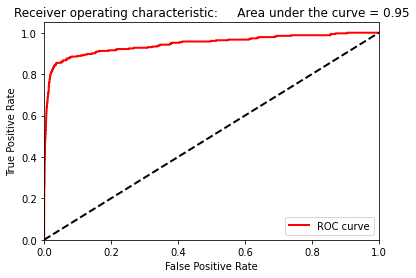

In [61]:
anomalyScoresSRP = anomaly_scores(X_train, X_train_SRP_inverse)
plotResults(y_train, anomalyScoresSRP)

## 비거리 기반 차원 축소

### 사전 학습

* 사전 학습 알고리즘은 원본 데이터로부터 희소 표현을 학습

* 학습된 사전의 벡터 가중 합계로 원본 데이터의 각 인스턴스를 재구성할 수 있음

* 이상 탐지를 위해 사전의 벡터 개수가 원본 차원보다 작도록 과소완전 사전을 학습

* 이 제약을 사용하면 더 자주 발생하는 장상 거래를 재구성하는 것은 더 쉬어지고 희귀한 사기 거래를 재구성하는 것은 더 어려워짐

In [63]:
n_components = 28
alpha = 1
batch_size = 200
n_iter = 10
random_state = 2022

In [65]:
miniBatchDictLearning = MiniBatchDictionaryLearning(
                                                    n_components=n_components,
                                                    alpha=alpha,
                                                    batch_size=batch_size,
                                                    n_iter=n_iter,
                                                    random_state=random_state)

In [66]:
miniBatchDictLearning.fit(X_train)

X_train_miniBatchDictLearning = miniBatchDictLearning.fit_transform(X_train)
X_train_miniBatchDictLearning = pd.DataFrame(data=X_train_miniBatchDictLearning, 
                                             index=X_train.index)

/usr/local/lib/python3.8/dist-packages/sklearn/decomposition/_dict_learning.py:2296: FutureWarning: 'n_iter' is deprecated in version 1.1 and will be removed in version 1.4. Use 'max_iter' and let 'n_iter' to its default value instead. 'n_iter' is also ignored if 'max_iter' is specified.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/decomposition/_dict_learning.py:2296: FutureWarning: 'n_iter' is deprecated in version 1.1 and will be removed in version 1.4. Use 'max_iter' and let 'n_iter' to its default value instead. 'n_iter' is also ignored if 'max_iter' is specified.
  warnings.warn(


In [67]:
X_train_miniBatchDictLearning_inverse = np.array(X_train_miniBatchDictLearning)\
                                          .dot(miniBatchDictLearning.components_)

X_train_miniBatchDictLearning_inverse = pd.DataFrame(data=X_train_miniBatchDictLearning_inverse,
                                                     index=X_train.index)

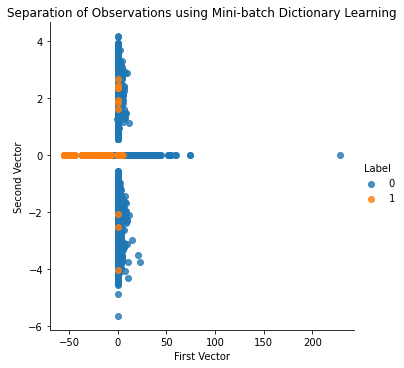

In [68]:
scatterPlot(X_train_miniBatchDictLearning,
            y_train, 
            "Mini-batch Dictionary Learning")

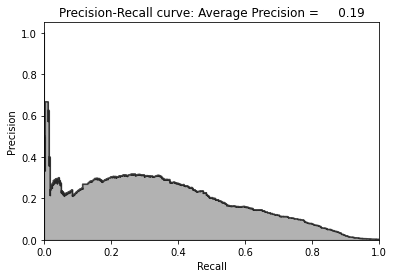

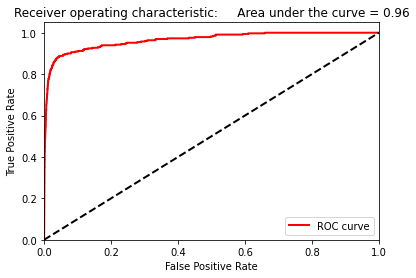

In [69]:
anomalyScoresMiniBatchDictLearning = anomaly_scores(X_train,
                                                   X_train_miniBatchDictLearning_inverse)
preds = plotResults(y_train,
                    anomalyScoresMiniBatchDictLearning,
                    True)

### ICA

In [71]:
n_components = 27
algorithm = 'parallel'
whiten = True
max_iter = 200
random_state = 2022

In [72]:
fastICA = FastICA(n_components=n_components,
                  algorithm=algorithm,
                  whiten=whiten,
                  max_iter=max_iter,
                  random_state=random_state)

In [73]:
X_train_fastICA = fastICA.fit_transform(X_train)
X_train_fastICA = pd.DataFrame(data=X_train_fastICA,
                               index=X_train.index)

/usr/local/lib/python3.8/dist-packages/sklearn/decomposition/_fastica.py:708: FutureWarning: Starting in v1.3, whiten=True should be specified as whiten='arbitrary-variance' (its current behaviour). This behavior is deprecated in 1.1 and will raise ValueError in 1.3.
  return self._fit_transform(X, compute_sources=True)


In [74]:
X_train_fastICA_inverse = fastICA.inverse_transform(X_train_fastICA)
X_train_fastICA_inverse = pd.DataFrame(data=X_train_fastICA_inverse,
                                       index=X_train.index)

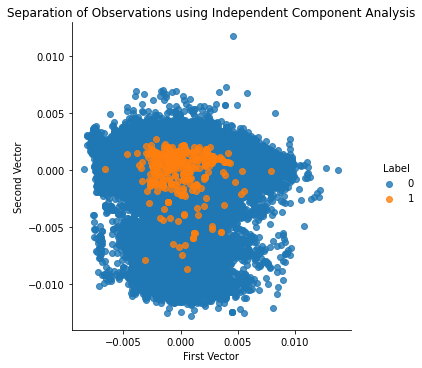

In [75]:
scatterPlot(X_train_fastICA, y_train, "Independent Component Analysis")

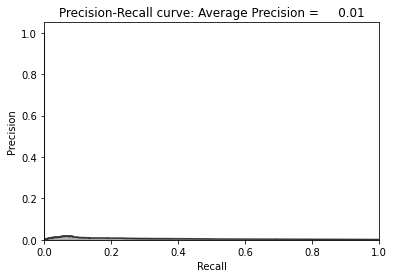

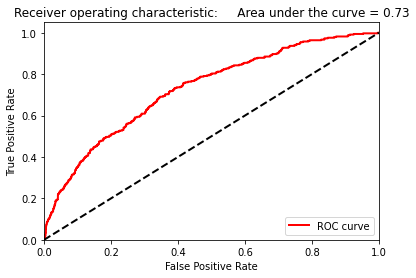

In [76]:
anomalyScoresFastICA = anomaly_scores(X_train, X_train_fastICA_inverse)
plotResults(y_train, anomalyScoresFastICA)

# 테스트 셋으로 이상치 탐지 성능 평가

## 일반 PCA

In [77]:
X_test_PCA = pca.transform(X_test)
X_test_PCA = pd.DataFrame(data=X_test_PCA, index=X_test.index)

In [78]:
X_test_PCA_inverse = pca.inverse_transform(X_test_PCA)
X_test_PCA_inverse = pd.DataFrame(data=X_test_PCA_inverse,
                                  index=X_test.index)

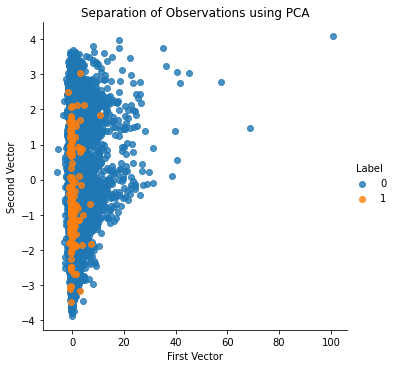

In [79]:
scatterPlot(X_test_PCA, y_test, "PCA")

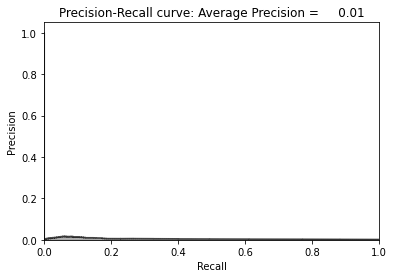

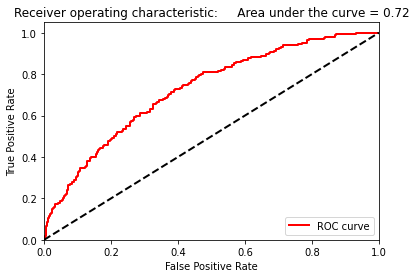

In [81]:
anomalyScoresPCA = anomaly_scores(X_test, X_test_PCA_inverse)
preds = plotResults(y_test, anomalyScoresPCA, True)

## ICA

In [82]:
X_test_fastICA = fastICA.transform(X_test)
X_test_fastICA = pd.DataFrame(data=X_test_fastICA, index=X_test.index)

In [83]:
X_test_fastICA_inverse = fastICA.inverse_transform(X_test_fastICA)
X_test_fastICA_inverse = pd.DataFrame(data=X_test_fastICA_inverse,
                                      index=X_test.index)

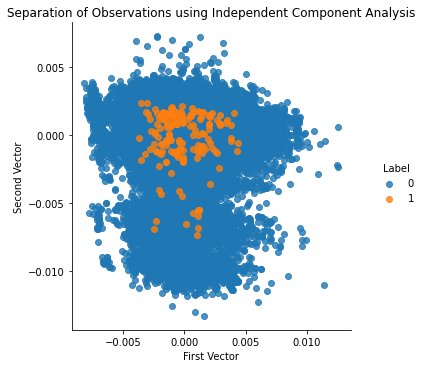

In [84]:
scatterPlot(X_test_fastICA, y_test, "Independent Component Analysis")

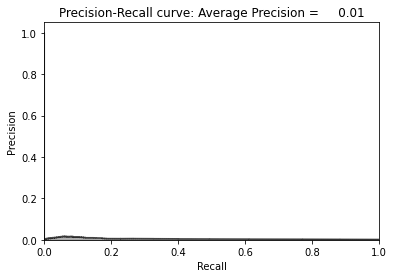

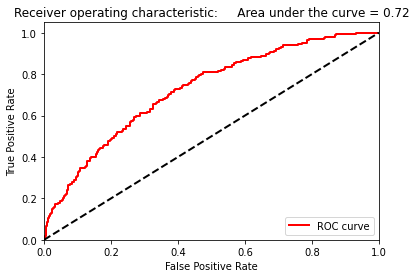

In [85]:
anomalyScoresFastICA = anomaly_scores(X_test, X_test_fastICA_inverse)
plotResults(y_test, anomalyScoresFastICA)

## 사전 학습

In [86]:
X_test_miniBatchDictLearning = miniBatchDictLearning.transform(X_test)
X_test_miniBatchDictLearning = pd.DataFrame(data=X_test_miniBatchDictLearning, index=X_test.index)

In [88]:
X_test_miniBatchDictLearning_inverse = np.array(X_test_miniBatchDictLearning)\
                                         .dot(miniBatchDictLearning.components_)

X_test_miniBatchDictLearning_inverse = pd.DataFrame(data=X_test_miniBatchDictLearning_inverse,
                                                    index=X_test.index)


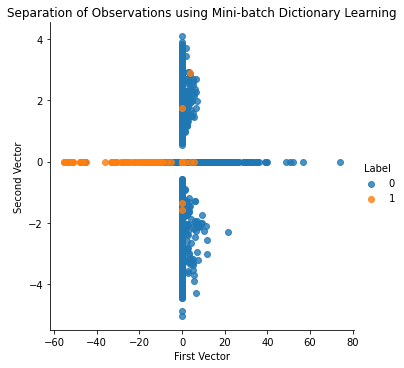

In [87]:
scatterPlot(X_test_miniBatchDictLearning,
            y_test,
            "Mini-batch Dictionary Learning")

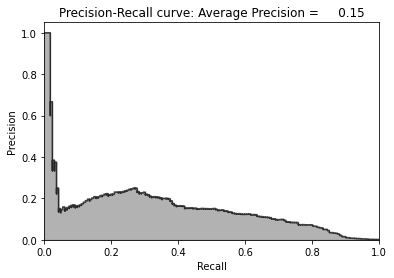

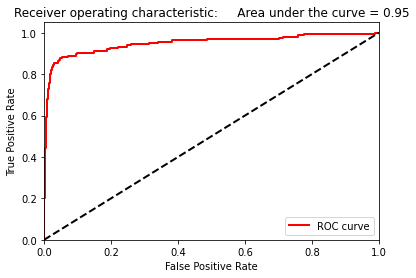

In [89]:
anomalyScoresMiniBatchDictLearning = anomaly_scores(X_test,
                                                    X_test_miniBatchDictLearning_inverse)
preds = plotResults(y_test,
                    anomalyScoresMiniBatchDictLearning, True)